# Semantic Segmenation of Smoke in GOES Satellite Imagery
## Dataset Notebook
---
* **Notebook Creator:** Rey Koki  rey.koki@noaa.gov (1,2)

* **Affiliations:**
    1. Cooperative Institute for Research for Environmental Sciences ([CIRES](https://cires.colorado.edu/))
    2. NOAA Global Systems Laboratory ([GSL](https://gsl.noaa.gov/))

 
* **Acknowledgements:**
    * funding support for this notebook was provided by NCEI

## Learning Objectives 

### The intented outcome of this tutorial is that the user will be able to:
1. Given a date and time, download and visualize [HMS smoke annotations](https://www.ospo.noaa.gov/Products/land/hms.html)
2. Download the corresponding [GOES satellite imagery from AWS](https://registry.opendata.aws/noaa-goes/)
3. Use SatPy to process GOES satellite imagery
4. Correlate and visualize the HMS smoke data to the processed GOES satellite imagery
5. View imagery in the created machine learning ready dataset
6. Download larger sample dataset

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/reykoki/Smoke_Semantic_Segmenation_Learning_Notebook/blob/main/Dataset.ipynb)

In [1]:
import os
if os.getcwd() == '/content':
    print("You are working in a Google colab notebook!\nLet's grab data and code from github.\n")
    !rm -r Get_GOES scripts figures data
    !git clone git@github.com:reykoki/Smoke_Semantic_Segmenation_Learning_Notebook.git
    !rm Smoke_Semantic_Segmenation_Learning_Notebook/Dataset.ipynb
    !mv Smoke_Semantic_Segmenation_Learning_Notebook/* .
    !pip install -r requirements.txt
import matplotlib.pyplot as plt
import numpy as np
import skimage
from glob import glob
import os
import time
from datetime import datetime
import wget
import pytz
import sys
sys.path.insert(1, './scripts')
from helper_functions import *

## 1. HMS Smoke Annotations
The most recent HMS annotation can be found [here](https://www.ospo.noaa.gov/data/land/fire/currenthms.jpg) and be seen below. The datafiles that contain the smoke annotations are provided in shapefile format, we use [geopandas](https://geopandas.org/en/stable/) to work with the data.

![](https://www.ospo.noaa.gov/data/land/fire/currenthms.jpg)

### 1.1. Define date and time

Use the format `YYYY/MM/DD HH:MM` to specify the time you'd like to grab HMS smoke data and GOES imagery for

In [2]:
dt_str = '2024/06/18 15:00'
dt = pytz.utc.localize(datetime.strptime(dt_str, '%Y/%m/%d %H:%M')) # convert to datetime object

sunrise on the west coast is at 13:31 UTC for 2024/06/18
sunset on the east coast is at 03:10 UTC for 2024/06/19
DOWNLOADING SMOKE:
hms_smoke20240618.zip
./data/smoke/hms_smoke20240618.zip

there are 6 smoke annotations in the time period requested


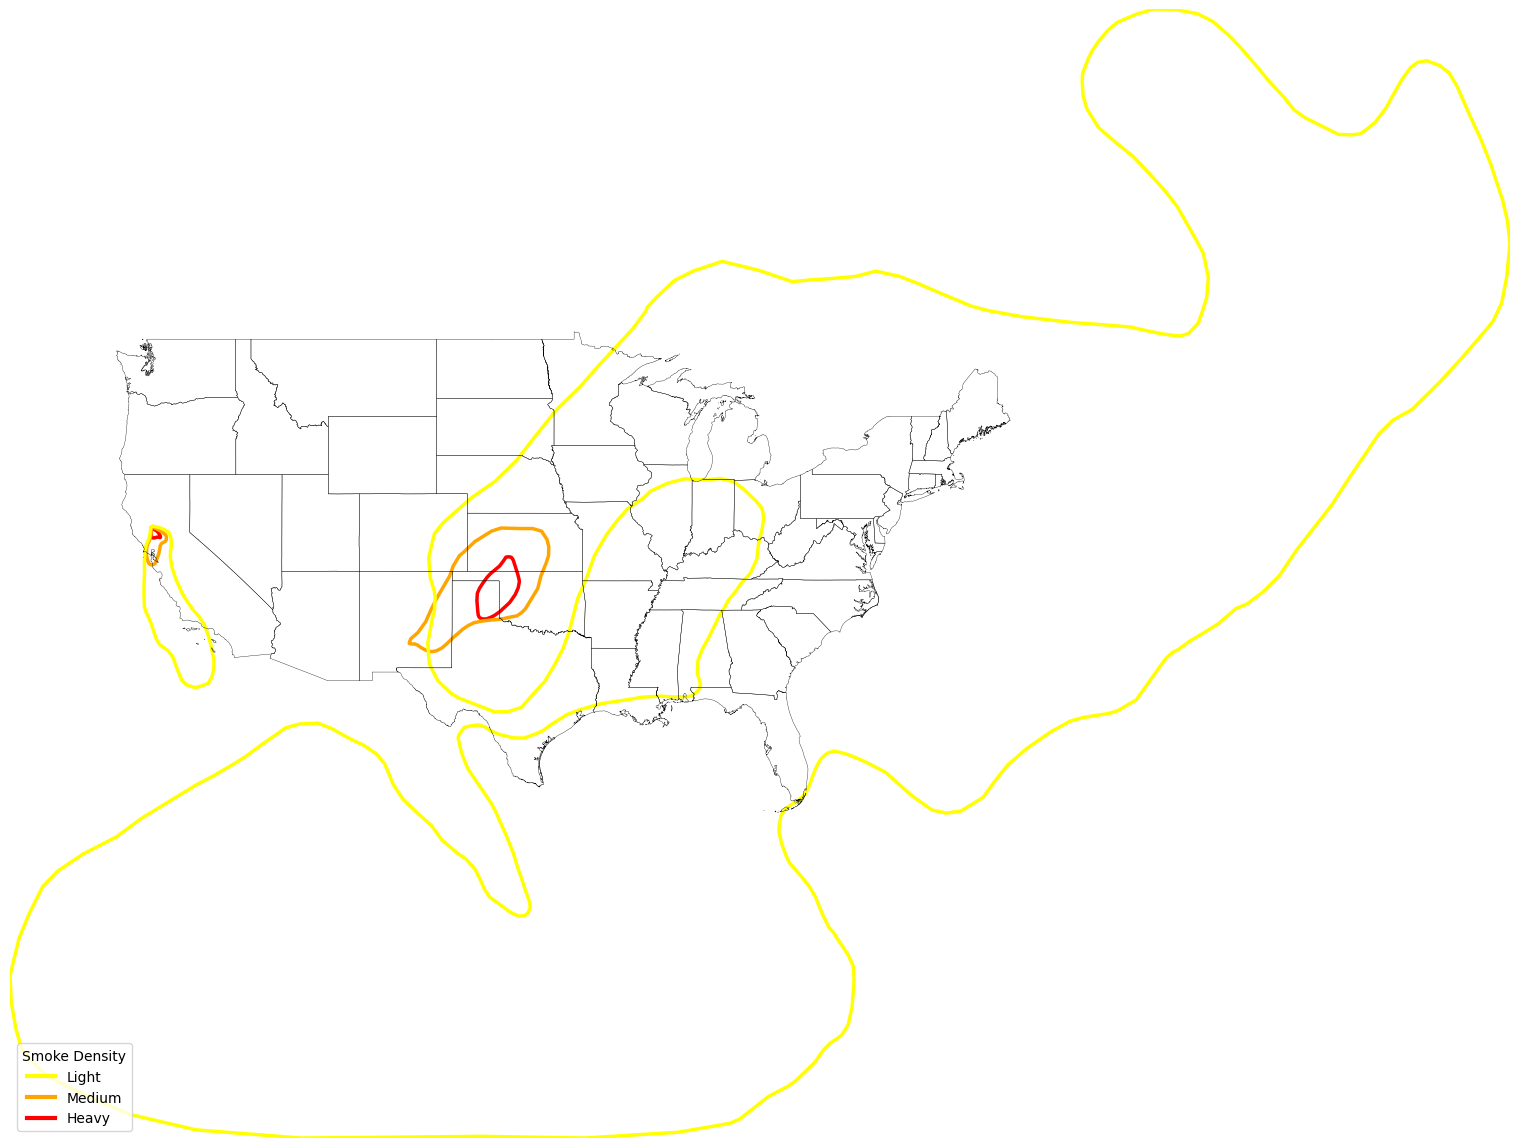

In [3]:
from grab_smoke import download_smoke #code located in /scripts/grab_smoke.py
smoke_shp = download_smoke(dt)

Using [geopandas](https://geopandas.org/en/stable/) we can convert the .shp files into python database objects so that the data can be easily accessed.

In [4]:
display(smoke_shp.head())

Satellite         Start           End Density  \
1   GOES-EAST  2024170 1230  2024170 1700   Light   
8   GOES-EAST  2024170 1230  2024170 1700  Medium   
18  GOES-EAST  2024170 1230  2024170 1700   Heavy   
0   GOES-WEST  2024170 1200  2024170 1530   Light   
9   GOES-EAST  2024170 1230  2024170 1700  Medium   

                                             geometry  
1   POLYGON ((-122.49294 39.35240, -122.53282 39.2...  
8   POLYGON ((-105.69097 33.24046, -105.60033 33.2...  
18  POLYGON ((-100.98606 34.51616, -100.81608 34.5...  
0   POLYGON ((-102.58308 28.14229, -102.45342 27.6...  
9   POLYGON ((-122.49476 39.31933, -122.50609 39.1...

## 2. GOES Satellite Imagery

For a more in-depth overview of GOES imagery, refer to the [GOES-R Series Data Book](https://www.goes-r.gov/downloads/resources/documents/GOES-RSeriesDataBook.pdf).

### 2.1. Bands
To create a true color image, we use the following bands from the Advanced Baseline Imager Level 1b CONUS (ABI-L1b-RadC) product.

| Band | Descirption | Center Wavelength ($\mu$m) | Spatial Resolution (km) |
| :-: | :-: | :-: | :-: |
| C01 | Blue visible | 0.47 | 1 |
| C02 | Red visible | 0.64 | 0.5 |
| C03 | Veggie near infrared | 0.865 | 1 |

A new ABI-L1b-RadC data file is produced every 5 minutes from both GOES-East and GOES-West and provided in netCDF4 format. 

![GOES-16](https://cdn.star.nesdis.noaa.gov/GOES16/ABI/CONUS/GEOCOLOR/GOES16-CONUS-GEOCOLOR-625x375.gif "GOES")


In [7]:
from grab_goes import download_goes
sat_fns = download_goes(dt)

for the datetime 2024-06-18 15:00:00+00:00:
sunrise is at: 2024-06-18 13:31:12+00:00
sunset is at: 2024-06-18 00:37:48+00:00


TypeError: ClientArgsCreator.compute_endpoint_resolver_builtin_defaults() missing 2 required positional arguments: 'credentials' and 'account_id_endpoint_mode'

## 3. Use Satpy to process GOES satellite imagery

#### ***NOTE:*** running this will take a few minutes

### 3.1. True Color Composite

We use [Satpy](https://satpy.readthedocs.io/en/stable/) to apply a composite of corrections based on algorithms to create a CIMSS True Color compositition for GOES ABI data. Refer to the CIMSS True Color [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018EA000379) and the [quick guide](https://cimss.ssec.wisc.edu/goes/OCLOFactSheetPDFs/ABIQuickGuide_CIMSSRGB_v2.pdf) for more information on this composite.

The corrections applied using the CIMSS True Color composite:
- **true color** - correction to make the image look closer to what our eyes would see (it uses a combination of C01, C02 and C03 to make an approximation to green).
- **solar zenith angle** - correction for atmospheric interactions with the light due to the solar zenith angle.
- **rayleigh scattering** - correction for how different wavelengths scatter off of particular atmposheric particles.

In [24]:
composite = ['cimss_true_color_sunz_rayleigh'] # define the true color composite

### 3.2. Lambert Conformal Conic Projection

Additionally, we transform the image onto a [Lambert conformal conic projection](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) in order to reduce the distortion that come with the [geostationary azimuthal projection](https://proj.org/en/9.2/operations/projections/geos.html).

In [25]:
import cartopy.crs as ccrs
def get_proj():
    lcc_proj = ccrs.LambertConformal(central_longitude=262.5,
                                     central_latitude=38.5,
                                     standard_parallels=(38.5, 38.5),
                                     globe=ccrs.Globe(semimajor_axis=6371229,
                                                      semiminor_axis=6371229))
    return lcc_proj
extent=[-2.4e6, -1.5e6, 2.3e6, 1.4e6] # extent for CONUS in meters for LCC projection

### 3.3. Get Satpy Scene Object

Once the satellite data has been downloaded to the local disk, you can load the weather satellite data in a Satpy `Scene` object. 

We then use a `pyresample` `create_area_def` function to define the area the projection and bounds/extents of the data.

In [21]:
from satpy import Scene
from pyresample import create_area_def

# get the Satpy Scene object
def get_scn(fns, to_load, extent, res=3000, proj=get_proj(), reader='abi_l1b', print_info=False):
    scn = Scene(reader=reader, filenames=fns)    
    scn.load(to_load, generate=False)
    my_area = create_area_def(area_id='my_area',
                              projection=proj,
                              resolution=res,
                              area_extent=extent
                              )
    if print_info:
        print("Available channels in the Scene object:\n", scn.available_dataset_names())
        print("\nArea definitition:\n",my_area)    
    new_scn = scn.resample(my_area) # resamples datasets and resturns a new scene object
    return new_scn
    
res = 5000 # 5km resolution
scn = get_scn(sat_fns, composite, extent, res, print_info=True) # get satpy scn object
crs = scn[composite[0]].attrs['area'].to_cartopy_crs() # the crs object will have the area extent for plotting

Available channels in the Scene object:
 ['C01', 'C02', 'C03']

Area definitition:
 Area ID: my_area
Description: my_area
Projection: {'R': '6371229', 'lat_0': '38.5', 'lat_1': '38.5', 'lat_2': '38.5', 'lon_0': '262.5', 'no_defs': 'None', 'proj': 'lcc', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 940
Number of rows: 580
Area extent: (-2400000.0, -1500000.0, 2300000.0, 1400000.0)


#### 3.3.1. Get RGB from Scene Object

#### ***NOTE:*** running this will take a few minutes

In [6]:
def get_RGB(scn, composite):
    # computationally expensive part
    RGB = get_enhanced_image(scn[composite]).data.compute().data
    # reorder before computing for plotting
    RGB = np.einsum('ijk->jki', RGB)
    RGB[np.isnan(RGB)] = 0 
    return RGB
RGB = get_RGB(scn, composite[0]) # from the scene object, extract RGB data for plotting

NameError: name 'scn' is not defined

## 4. Visualize HMS smoke annotations on GOES imagery

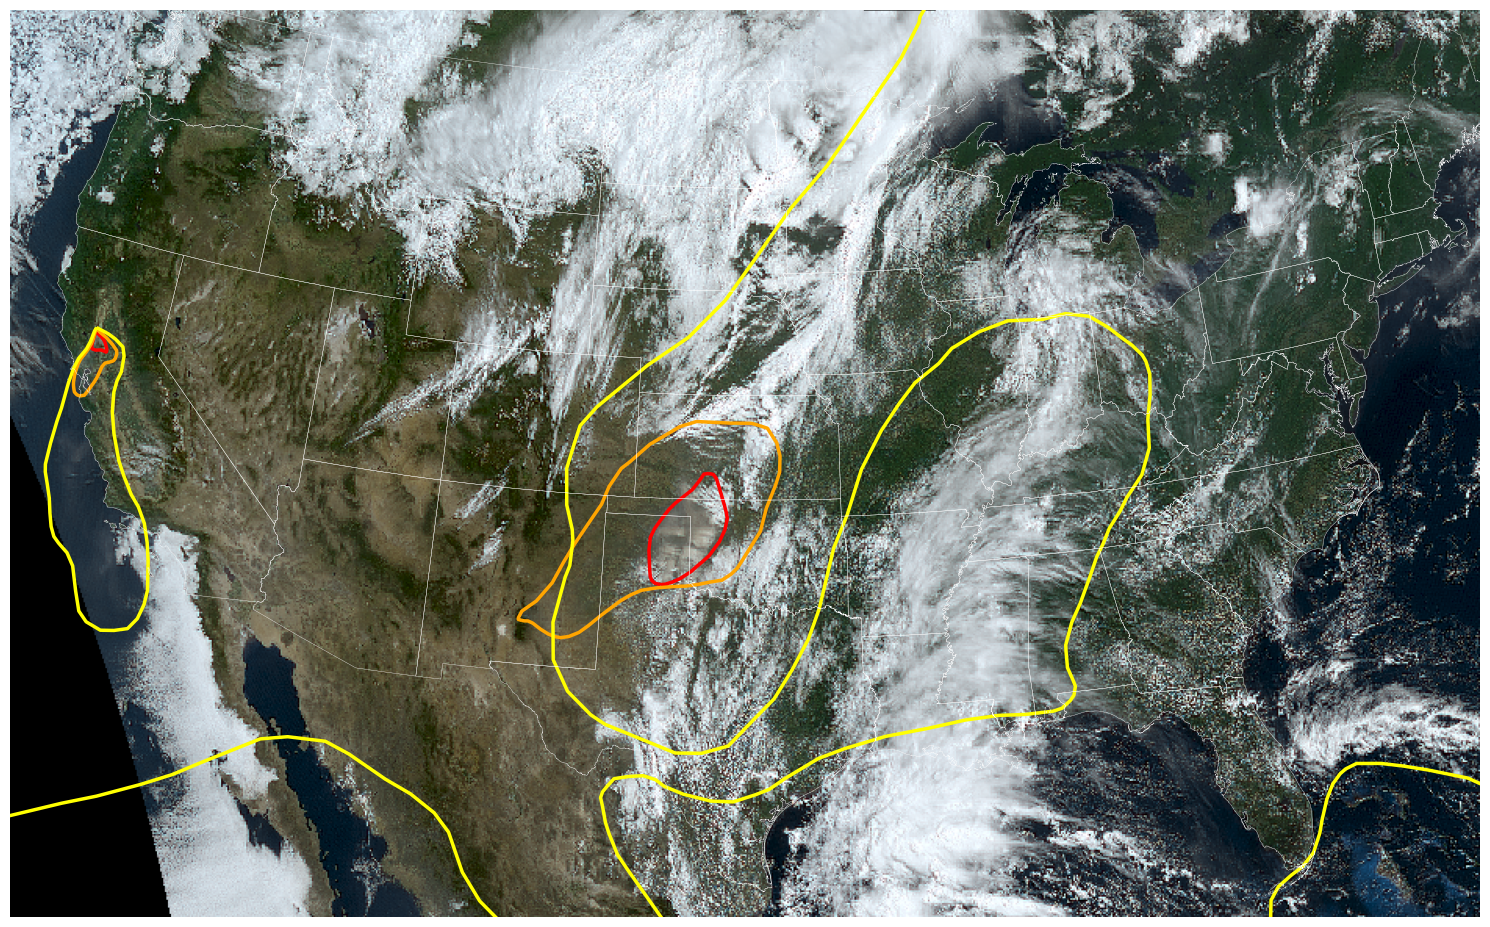

In [22]:
def plot_CONUS_Smoke(data, crs, smoke):
    states = get_states(crs) # ./scripts/helper_functions.py
    smoke = smoke.to_crs(crs) # match the smoke to the same projection as GOES imagery
    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection=crs)
    plt.imshow(data, transform=crs, extent=crs.bounds, origin='upper')
    states.boundary.plot(ax=ax, edgecolor='white', linewidth=.25)
    smoke.loc[smoke['Density'] == 'Heavy'].plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2.5)
    smoke.loc[smoke['Density'] == 'Medium'].plot(ax=ax, facecolor='none', edgecolor='orange', linewidth=2.5)
    smoke.loc[smoke['Density'] == 'Light'].plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2.5)
    plt.axis('off')
    fig.tight_layout()
    #plt.savefig('conus.png')
    plt.show()
plot_CONUS_Smoke(RGB, crs, smoke_shp)

## 5. Visualize machine learning data and labels

At full resolution, the 3-channel CONUS satellite imagery contains 180 million pixels. With an increase in the number of pixels, there is a increase in the computational cost to run the machine learning model. For efficiency, we will work with images sized down to ~200,000 pixels but still cover 250 km$^2$.

### 5.1. Define filename from dataset

In [26]:
fn = 'G16_s20232680016174_e20232680018547_22.tif'

#### 5.1.1. plot RGB

2023/09/25 00:16 UTC


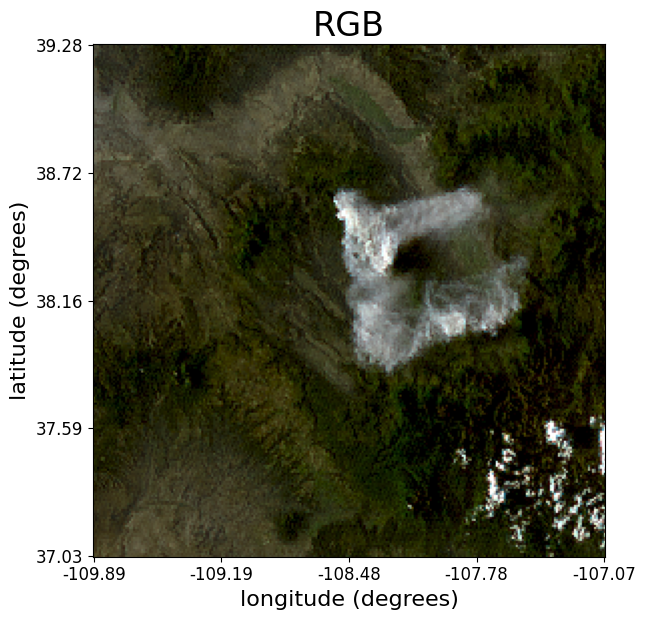

In [31]:
from plot_tifs import plot_RGB,  plot_densities_from_processed_data, plot_R_G_B, plot_labels # code located in /scripts/plot_tifs.py
plot_RGB(fn)

#### 5.1.2. plot RGB channels

"Green" is a combination of the red, blue and veggie band.

G16_s20232680016174_e20232680018547_22.tif
center lat, lon: (38.31, -108.66)


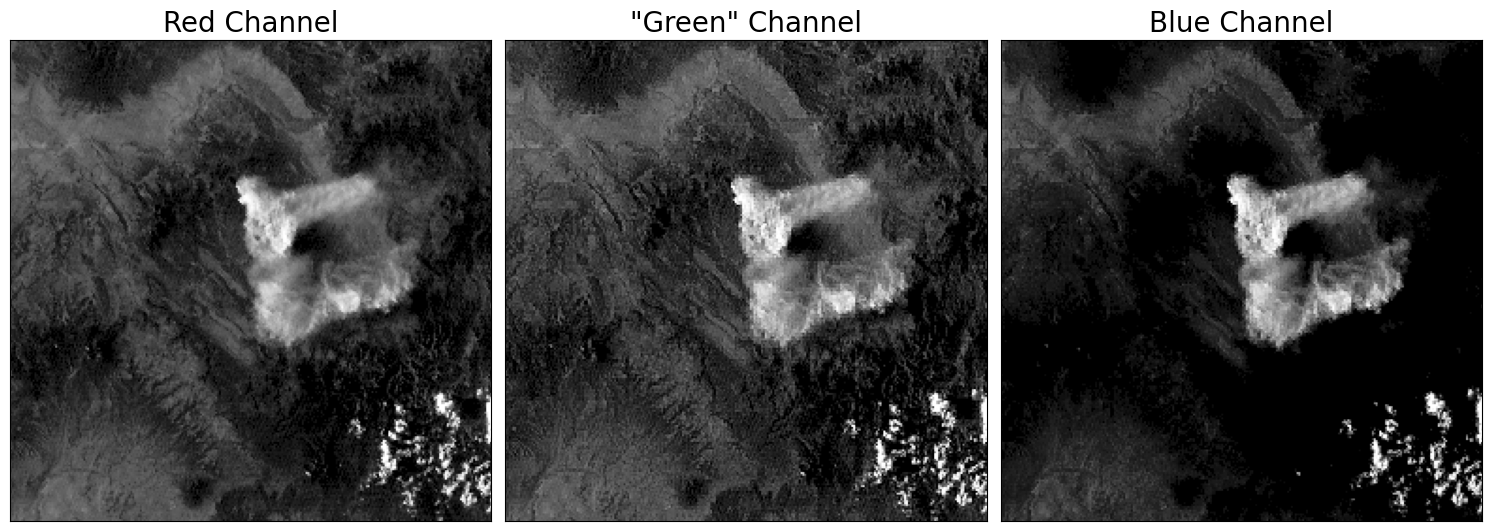

In [28]:
plot_R_G_B(fn)

#### 5.1.3. plot smoke densities

The labels are divided into 3 layers for each smoke density.

G16_s20232680016174_e20232680018547_22.tif


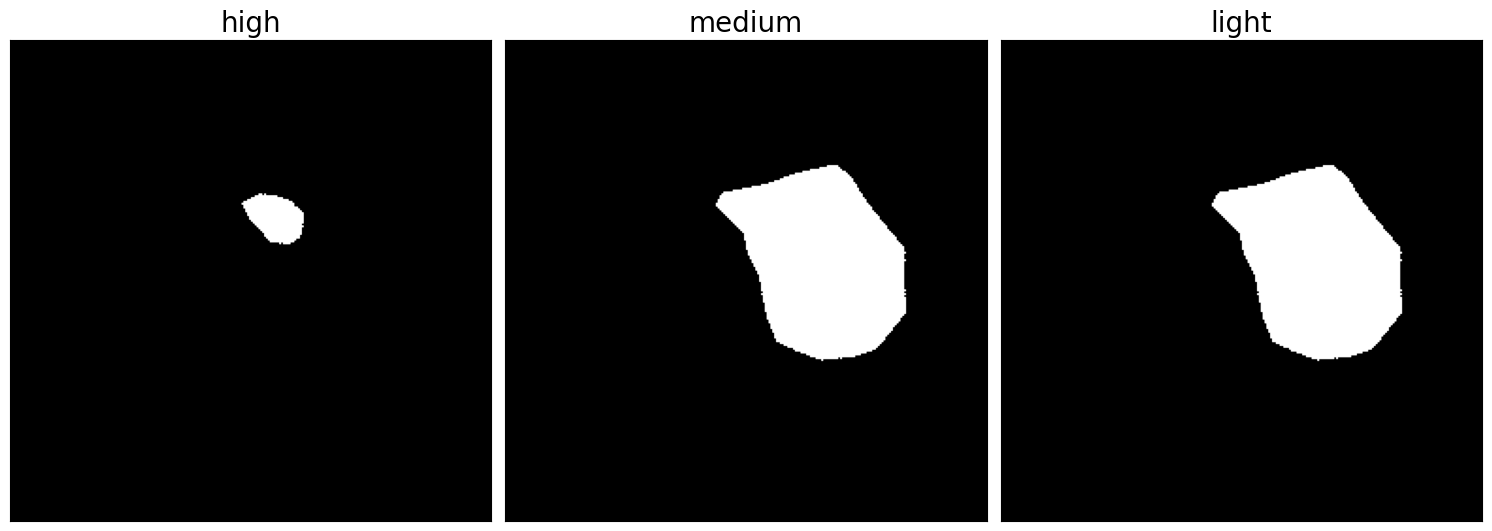

In [29]:
plot_labels(fn)

#### 5.1.3. plot smoke densities ontop of GOES data

Red, orange and yellow correspond to high, medium and light densities of smoke.

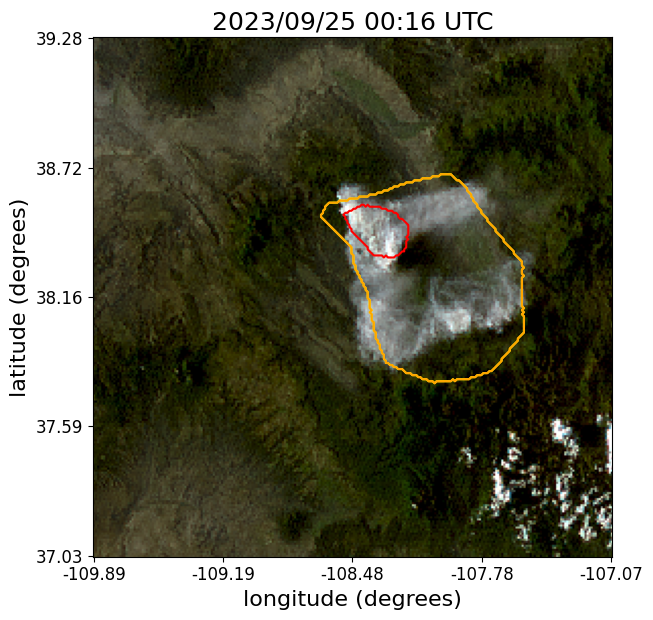

In [30]:
plot_densities_from_processed_data(fn)

## 6. Download larger sample dataset from Zenodo

In [33]:
import zipfile
import wget

download = input('do you want to download the larger 1.3 GB dataset? [y/n]')
if download == 'y' or download == 'Y':
    wget.download("https://zenodo.org/records/10946629/files/sample_dataset.zip?download=1")
    path_to_zip = "sample_dataset.zip"
    with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
      zip_ref.extractall('.')

do you want to download the larger 1.3 GB dataset? [y/n] n
